# Предсказание оттока сотрудников

Соревнование Kaggle: 
https://www.kaggle.com/t/e703142015c049318340d699fe881c36

Описание файлов
- train_data.csv - набор данных для обучения
- test_data.csv - набор данных для теста

Описание полей
- Age - возраст
- BusinessTravel - частота командировок
- Department - отдел
- DistanceFromHome - расстояние от дома в км
- Education - уровень образования
- EducationField - сфера образования
- Gender - пол
- JobRole - должностная роль
- MaritalStatus - семейное положение
- MonthlyIncome - ежемесячный доход
- NumCompaniesWorked - кол-во компаний, в которых работал сотрудник
- PercentSalaryHike - процент повышения з/п за время работы
- StandardHours - стандартная продолжительность рабочего дня
- StockOptionLevel - уровень опциона на акции
- TotalWorkingYears - общий трудовой стаж
- TrainingTimesLastYear - общее время дополнительного обучения
- YearsAtCompany - стаж работы в данной компании
- YearsSinceLastPromotion - кол-во лет с последнего повышения
- YearsWithCurrManager - кол-во лет работы с текущим менеджером
- *Attrition - ушел работник или нет, целевая переменная*

## Загружаем и чистим данные

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
%%capture
!wget https://www.dropbox.com/s/z72mi1fh0cmadcv/train_data.csv
!wget https://www.dropbox.com/s/7mzi72914hpo74t/test_data.csv

In [ ]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [ ]:
# убираем задвоенный индекс
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
#видим, что столбцы с числами в формате числа, это хорошо; объекты типа object закодируем далее
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2205 non-null   int64  
 1   BusinessTravel           2205 non-null   object 
 2   Department               2205 non-null   object 
 3   DistanceFromHome         2205 non-null   int64  
 4   Education                2205 non-null   int64  
 5   EducationField           2205 non-null   object 
 6   Gender                   2205 non-null   object 
 7   JobRole                  2205 non-null   object 
 8   MaritalStatus            2205 non-null   object 
 9   MonthlyIncome            2205 non-null   int64  
 10  NumCompaniesWorked       2194 non-null   float64
 11  PercentSalaryHike        2205 non-null   int64  
 12  StandardHours            2205 non-null   int64  
 13  StockOptionLevel         2205 non-null   int64  
 14  TotalWorkingYears       

In [ ]:
#посмотрим статистику, транспонируем для удобства
train_data.describe().T 

,count,mean,std,min,25%,50%,75%,max
Age,2205.0,36.669841,9.078445,18.0,30.0,35.0,42.0,60.0
DistanceFromHome,2205.0,9.409524,8.134342,1.0,2.0,7.0,15.0,29.0
Education,2205.0,2.895692,1.046125,1.0,2.0,3.0,4.0,5.0
MonthlyIncome,2205.0,65151.972789,47711.864224,10510.0,28750.0,48770.0,83460.0,199990.0
NumCompaniesWorked,2194.0,2.648587,2.490846,0.0,1.0,2.0,4.0,9.0
PercentSalaryHike,2205.0,15.209524,3.638322,11.0,12.0,14.0,18.0,25.0
StandardHours,2205.0,8.000000,0.000000,8.0,8.0,8.0,8.0,8.0
StockOptionLevel,2205.0,0.822222,0.874708,0.0,0.0,1.0,1.0,3.0
TotalWorkingYears,2199.0,11.224193,7.896927,0.0,6.0,10.0,15.0,40.0
TrainingTimesLastYear,2205.0,2.798186,1.313616,0.0,2.0,3.0,3.0,6.0


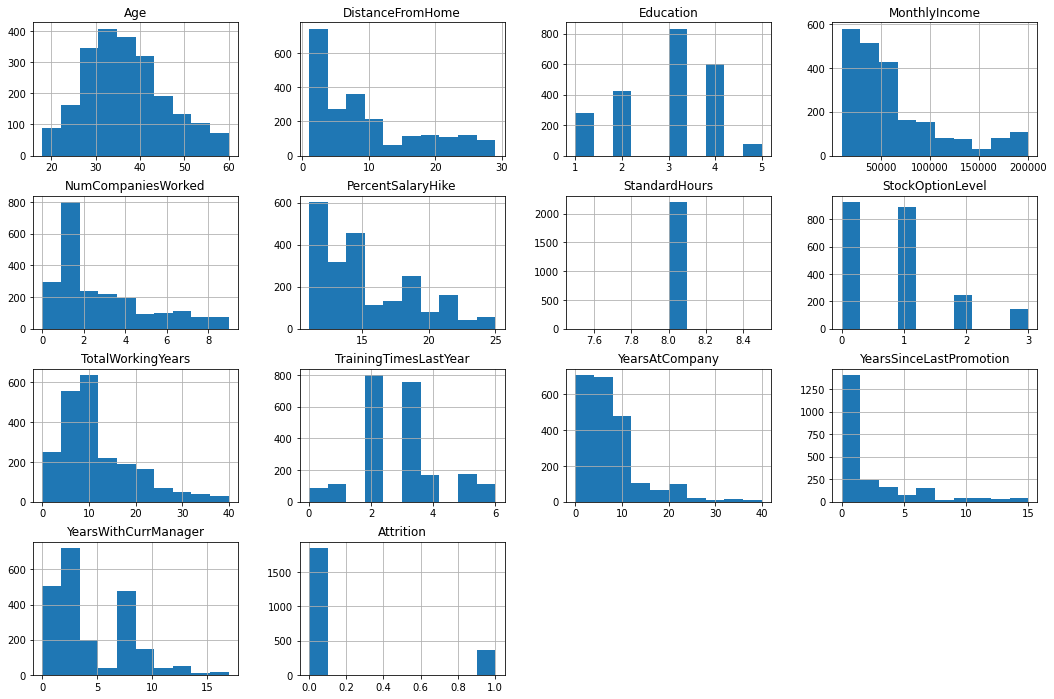

In [ ]:
# посмотрим возможные выбросы
train_data.hist(figsize=(18, 12));

In [ ]:
# уберем близких к пенсии и уровень образорвания "5"
train_data = train_data[
    (train_data['Education'] <= 4) &
    (train_data['TotalWorkingYears'] < 24) 
]
train_data.describe().T 

,count,mean,std,min,25%,50%,75%,max
Age,1939.0,35.385250,8.274048,18.0,30.0,35.0,40.0,60.0
DistanceFromHome,1939.0,9.384219,8.131046,1.0,2.0,7.0,15.0,29.0
Education,1939.0,2.826199,0.978729,1.0,2.0,3.0,4.0,4.0
MonthlyIncome,1939.0,65872.919030,48222.261147,10510.0,29065.0,49630.0,84685.0,199990.0
NumCompaniesWorked,1930.0,2.553368,2.491770,0.0,1.0,1.0,4.0,9.0
PercentSalaryHike,1939.0,15.214028,3.650931,11.0,12.0,14.0,18.0,25.0
StandardHours,1939.0,8.000000,0.000000,8.0,8.0,8.0,8.0,8.0
StockOptionLevel,1939.0,0.813822,0.869679,0.0,0.0,1.0,1.0,3.0
TotalWorkingYears,1939.0,9.482207,5.630346,0.0,6.0,9.0,12.0,23.0
TrainingTimesLastYear,1939.0,2.818979,1.313473,0.0,2.0,3.0,3.0,6.0


In [ ]:
#посчитаем медиану и заполним ими пустые значения в таблице
train_median = train_data.median() 
train_data.fillna(train_median, inplace=True)

test_median = test_data.median()
test_data.fillna(test_median, inplace=True)

train_median

Age                           35.0
DistanceFromHome               7.0
Education                      3.0
MonthlyIncome              49630.0
NumCompaniesWorked             1.0
PercentSalaryHike             14.0
StandardHours                  8.0
StockOptionLevel               1.0
TotalWorkingYears              9.0
TrainingTimesLastYear          3.0
YearsAtCompany                 5.0
YearsSinceLastPromotion        1.0
YearsWithCurrManager           3.0
Attrition                      0.0
dtype: float64

In [ ]:
#выделяем целевую переменну, обзначающую ушел работник или нет и отделим ее от входных данных
target_variable_name = 'Attrition' 
train_values = train_data[target_variable_name]
train_points = train_data.drop(target_variable_name, axis=1)

# задача не сбалансирована, уволиышихся сотрудников меньше
train_values.value_counts()

0    1605
1     334
Name: Attrition, dtype: int64

In [ ]:
# проверим размерность стобцов
train_points.shape, train_values.shape

((1939, 19), (1939,))

In [ ]:
# записываем столбец id в отдельную переменную, он нам понадобится в конце для итоговых результатов
idx = test_data['index'] 
test_points = test_data.drop('index', axis=1) # удаляем его из тестовой выборки

## Обработываем текстовые переменные

In [ ]:
# выбираем кодировщик OneHotEncoder (если признак есть, он создаст новый столбец со значением 1)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()

text_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
train_points[text_features].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus
0,Travel_Rarely,Research & Development,Medical,Male,Research Director,Single
1,Travel_Rarely,Research & Development,Technical Degree,Female,Sales Executive,Married
2,Travel_Frequently,Research & Development,Medical,Female,Laboratory Technician,Married
3,Travel_Rarely,Research & Development,Medical,Male,Sales Executive,Single
4,Travel_Rarely,Research & Development,Medical,Male,Research Scientist,Married


In [ ]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
train_points_onehot = onehot_encoder.fit_transform(train_points[text_features]).toarray()
# применяем полученное преобразование к тестовой выборке, результат переводим в массив
test_points_onehot = onehot_encoder.transform(test_points[text_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names(text_features)
columns[:]

array(['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single'], dtype=object)

In [ ]:
# преобразуем в датафрейм
train_points_onehot = pd.DataFrame(train_points_onehot, index=train_points.index, columns=columns)
test_points_onehot = pd.DataFrame(test_points_onehot, index=test_points.index, columns=columns)

In [ ]:
# соединяем новую табличку с исходной
train_points_new = pd.concat([train_points, train_points_onehot], axis=1)
test_points_new = pd.concat([test_points, test_points_onehot], axis=1)

# удаляем старые категориальные признаки
train_points_new = train_points_new.drop(columns=text_features)
test_points_new = test_points_new.drop(columns=text_features)

In [ ]:
# проверим, какая красота получилась
train_points_new.head(5)

,Age,DistanceFromHome,Education,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,40,2,3,47750,3.0,15,8,1,15.0,3,5,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,31,28,4,127420,1.0,11,8,0,10.0,4,10,0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,35,3,3,22580,1.0,11,8,1,2.0,2,2,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33,2,2,24400,0.0,18,8,3,4.0,4,3,0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,32,2,3,57470,1.0,13,8,0,8.0,0,8,0,7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


##   Обучаем модель

In [ ]:
# используем градиентный бустинг
import xgboost as xgb 
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0) # создаем прототип модели
xgboost_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=0)

### Grid Search

In [ ]:
# используем Grid search для поиска лучших параметров модели
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# среди каких вариантов будем выбирать
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [11, 12, 13],
    'learning_rate': [0.35, 0.4, 0.45]
}

In [ ]:
# k-fold для кросс-валидации (количество разбиений)
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
kfold

KFold(n_splits=5, random_state=123, shuffle=True)

In [ ]:
# запускаем Grid search для нашей модели, с вариантами поиска и количеством разбиений для кросс-валидации
CV_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='roc_auc', cv=kfold)

In [ ]:
# положим наши данные в модель для поиска лучших параметров
CV_xgb.fit(train_points_new, train_values)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.35, 0.4, 

In [ ]:
# наилучшие параметры 
best_params = CV_xgb.best_params_
best_params

{'learning_rate': 0.4, 'max_depth': 12, 'n_estimators': 200}

In [ ]:
# сохраним в переменную, чтобы каждый раз не запускать сложный расчет
# best_params = {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 300}
# best_params = {'learning_rate': 0.4, 'max_depth': 12, 'n_estimators': 200}

### XGBoost

In [ ]:
# инициализируем модель с лучшими параметрами из Grid Search
best_xgb_model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0, **best_params)

In [ ]:
# сделаем кросс-валидацию и выведем roc_auc
roc_auc_scores = cross_val_score(best_xgb_model, train_points_new, train_values, cv=kfold, scoring='roc_auc')
roc_auc_scores

array([0.93393872, 0.91910746, 0.9226697 , 0.8964614 , 0.96270514])

In [ ]:
roc_auc_scores.mean()

0.9269764839360862

In [ ]:
# обучаем модель на обучающей выборке с лучшими параметрами модели
best_xgb_model.fit(train_points_new, train_values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=0)

In [ ]:
# получим предсказани; целевая метрика - ROC AUC, поэтому нужно получить вероятности принадлежности к классу 1
test_predictions = best_xgb_model.predict_proba(test_points_new)[:, 1]
test_predictions

array([9.8514807e-01, 1.8818209e-04, 8.8844291e-04, ..., 1.7493606e-03,
       6.0241758e-03, 7.0158765e-02], dtype=float32)

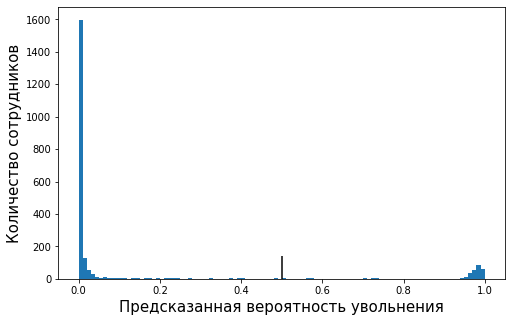

In [ ]:
# изобразим на графике

plt.figure(figsize=(8, 5))
# строим распределение вероятностей 
plt.hist(test_predictions, bins=100)
# строим прямую линию в точке 0.5
plt.vlines(0.5, 0, 140)
plt.xlabel('Предсказанная вероятность увольнения', fontsize=15)
plt.ylabel('Количество сотрудников', fontsize=15);

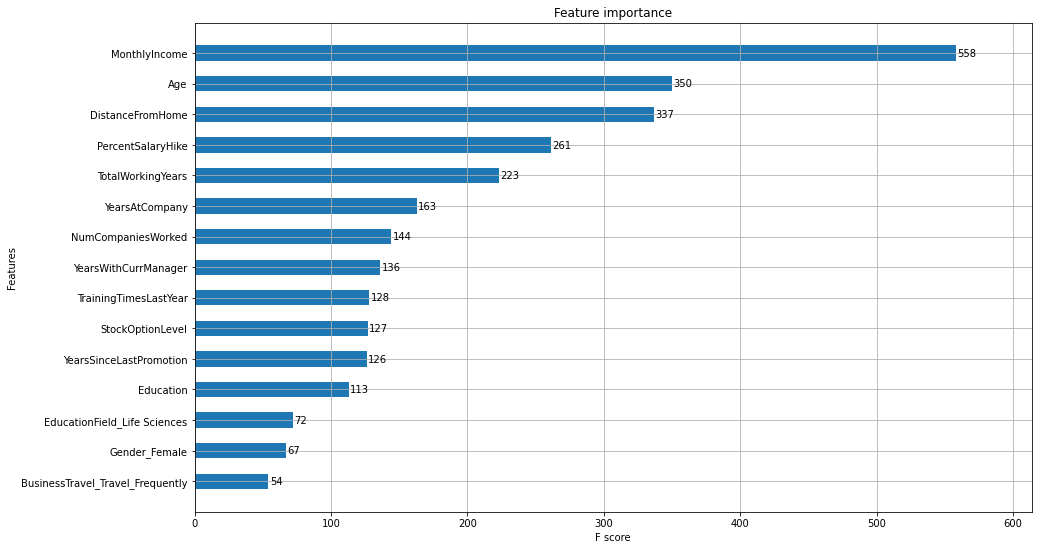

In [ ]:
# посмотрим, какие именно факторы влияют на увольнение
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15, 9))
plot_importance(best_xgb_model, max_num_features=15, height=0.5, ax=ax)
plt.show()

### Загрузка результатов

In [ ]:
result = pd.DataFrame(columns=['index', 'Attrition']) # создадим таблицу и записываем в нее полученные данные
result['index'] = idx
result['Attrition'] = test_predictions

In [ ]:
# сохраняем и загружаем полученный результат
result.to_csv('result.csv', index=False)
from google.colab import files
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>